In [23]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Data Preprocessing

### **Normalization:** The pixel values are scaled to the range [0, 1] for better training. Normalization helps in speeding up the convergence during training.

### **Reshape:** The images are reshaped to include a channel dimension (for grayscale images), making it compatible with the neural network input.

In [24]:
# Load MNIST dataset
(X_train, Y_train), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)  # Reshape to (28, 28, 1)

# Build Generator

### This generator is part of a CGAN that generates images according to the given label.

### It combines random noise with a label to create a specific image class (e.g., generating a "2" when the label is 2).

In [25]:
# Generator with label input
def build_generator():
    noise_input = layers.Input(shape=(100,))
    label_input = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Embedding(10, 100)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    model_input = layers.multiply([noise_input, label_embedding])

    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return tf.keras.Model([noise_input, label_input], model(model_input))

generator = build_generator()
build_generator().summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_16 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 1, 100)               1000      ['input_16[0][0]']            
                                                                                                  
 input_15 (InputLayer)       [(None, 100)]                0         []                            
                                                                                                  
 flatten_8 (Flatten)         (None, 100)                  0         ['embedding_6[0][0]']         
                                                                                            

# Build Discriminator Model

### This model is a discriminator in a CGAN. It takes both an image and a label as input and determines whether the image is real or fake, based on the given label.

### By combining the image and label inputs, the discriminator can ensure that the image corresponds to the specified label before deciding if it's real or fake.

In [26]:
# Discriminator with label input
def build_discriminator():
    img_input = layers.Input(shape=(28, 28, 1))
    label_input = layers.Input(shape=(1,), dtype='int32')

    # Embedding the label input to match the shape of the image input
    label_embedding = layers.Embedding(10, 28 * 28)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((28, 28, 1))(label_embedding)

    # Concatenate the image and label embeddings along the channel dimension
    merged_input = layers.concatenate([img_input, label_embedding], axis=-1)

    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 2)))  # Update the input shape here
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return tf.keras.Model([img_input, label_input], model(merged_input))

# Build the discriminator and print the summary
discriminator = build_discriminator()
discriminator.summary()


Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_18 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_7 (Embedding)     (None, 1, 784)               7840      ['input_18[0][0]']            
                                                                                                  
 flatten_9 (Flatten)         (None, 784)                  0         ['embedding_7[0][0]']         
                                                                                                  
 input_17 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                            

# Build and Compile the Models

### The **discriminator** is compiled with the Adam optimizer and binary cross-entropy loss since it needs to classify whether the input is real or fake (binary classification). The accuracy metric is also tracked.

### The **GAN** model is created by combining the generator and discriminator. It takes random noise and a label as input, generates an image, and then passes that image (along with the label) to the discriminator to check if it's real or fake.

### The GAN is also compiled with binary cross-entropy loss since it still involves distinguishing between real and fake images.

In [27]:
# Build and compile models
generator = build_generator()
discriminator = build_discriminator()

discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input_noise = layers.Input(shape=(100,))
gan_input_label = layers.Input(shape=(1,))
generated_image = generator([gan_input_noise, gan_input_label])
gan_output = discriminator([generated_image, gan_input_label])

gan = tf.keras.Model([gan_input_noise, gan_input_label], gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Train the Function

### Two arrays, real and fake, are created to represent the target labels: 1 for real images and 0 for fake images.

### The loop runs for a specified number of epochs, where a random batch of real images and their corresponding labels is selected from the dataset for each iteration.

### **Random noise** is generated and fed into the generator (along with the labels) to create fake images.

### The **discriminator** is trained on both the real images (with label 1) and the generated (fake) images (with label 0). The final loss for the discriminator is the average of the two losses.

### The generator is trained through the GAN by trying to fool the discriminator into thinking the generated images are real. The target labels for this are 1 (real) because the generator is rewarded when it can make the discriminator believe its images are real.

In [28]:
# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images, labels = X_train[idx], Y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict([noise, labels])

        d_loss_real = discriminator.train_on_batch([real_images, labels], real)
        d_loss_fake = discriminator.train_on_batch([fake_images, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch([noise, labels], real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch)



# Saving Generated Images

### This function generates and saves images at each specified interval. It generates 10 images (for digits 0-9) by feeding random noise and the corresponding labels into the generator.

### The images are rescaled from the range [-1, 1] to [0, 1] for display. A 2x5 grid of images is created and displayed.

2/2 [==============================] - 0s 6ms/step
0 [D loss: 0.7766799926757812, acc.: 26.5625%] [G loss: 0.6756036281585693]
1/1 [==============================] - 0s 237ms/step


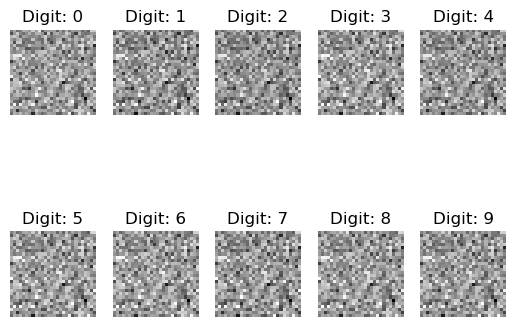

2/2 [==============================] - 0s 11ms/step


In [29]:
# Function to save generated images
def save_images(epoch):
    r, c = 2, 5  # Generate 10 images (2 rows, 5 columns)
    noise = np.random.normal(0, 1, (r * c, 100))
    labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Generate digits 0-9
    gen_images = generator.predict([noise, labels])
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].set_title(f"Digit: {labels[cnt]}")
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the CGAN
train(epochs=1000, batch_size=64, save_interval=1000)

# Question 01

## **Modify the CGAN to generate images for specific digits (e.g., generate only '7' or '9').**

2/2 [==============================] - 0s 6ms/step
0 [D loss: 0.5349909365177155, acc.: 51.5625%] [G loss: 0.3668687045574188]
1/1 [==============================] - 0s 213ms/step


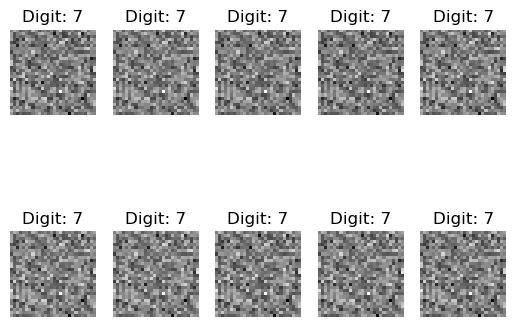

2/2 [==============================] - 0s 3ms/step
1000 [D loss: 0.12203948653768748, acc.: 96.09375%] [G loss: 4.020803451538086]
1/1 [==============================] - 0s 25ms/step


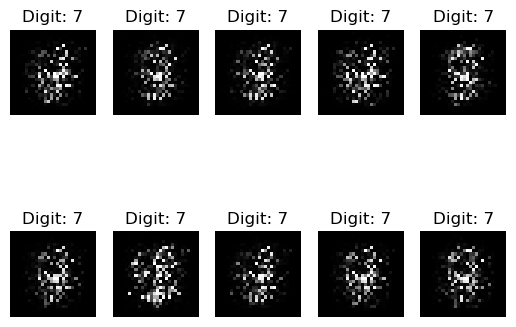

In [77]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load MNIST dataset
(X_train, Y_train), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)  # Reshape to (28, 28, 1)

# Generator with label input
def build_generator():
    noise_input = layers.Input(shape=(100,))
    label_input = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Embedding(10, 100)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    model_input = layers.multiply([noise_input, label_embedding])

    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return tf.keras.Model([noise_input, label_input], model(model_input))

generator = build_generator()

# Discriminator with label input
def build_discriminator():
    img_input = layers.Input(shape=(28, 28, 1))
    label_input = layers.Input(shape=(1,), dtype='int32')

    # Embedding the label input to match the shape of the image input
    label_embedding = layers.Embedding(10, 28 * 28)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((28, 28, 1))(label_embedding)

    # Concatenate the image and label embeddings along the channel dimension
    merged_input = layers.concatenate([img_input, label_embedding], axis=-1)

    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 2)))  # Update the input shape here
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return tf.keras.Model([img_input, label_input], model(merged_input))

discriminator = build_discriminator()

# Build and compile models
discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input_noise = layers.Input(shape=(100,))
gan_input_label = layers.Input(shape=(1,))
generated_image = generator([gan_input_noise, gan_input_label])
gan_output = discriminator([generated_image, gan_input_label])

gan = tf.keras.Model([gan_input_noise, gan_input_label], gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images, labels = X_train[idx], Y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict([noise, labels])

        d_loss_real = discriminator.train_on_batch([real_images, labels], real)
        d_loss_fake = discriminator.train_on_batch([fake_images, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch([noise, labels], real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch, digit=7)  # Change this to the desired digit, e.g., '7' or '9'

# Function to save generated images for a specific digit
def save_images(epoch, digit=7):
    r, c = 2, 5  # Generate 10 images (2 rows, 5 columns)
    noise = np.random.normal(0, 1, (r * c, 100))
    labels = np.full((r * c,), digit)  # Generate the specific digit
    gen_images = generator.predict([noise, labels])
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].set_title(f"Digit: {digit}")
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the CGAN
train(epochs=1001, batch_size=64, save_interval=1000)



# Question 02

## **Add label smoothing (e.g., replace real labels of 1 with random values between 0.9 and 1) during training. Analyze how label smoothing affects the training process and the quality of generated images.**


2/2 [==============================] - 0s 15ms/step
0 [D loss: 0.5099863111972809, acc.: 0.0%] [G loss: 0.40802639722824097]
1/1 [==============================] - 0s 485ms/step


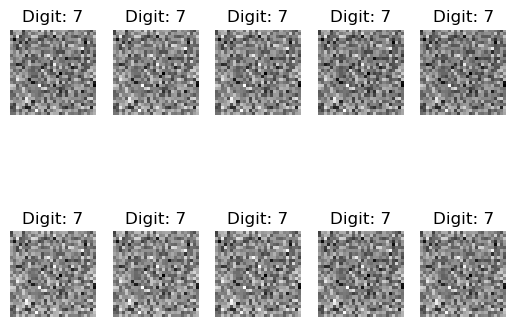

2/2 [==============================] - 0s 5ms/step
1000 [D loss: 0.1796557866036892, acc.: 49.21875%] [G loss: 3.8925371170043945]
1/1 [==============================] - 0s 28ms/step


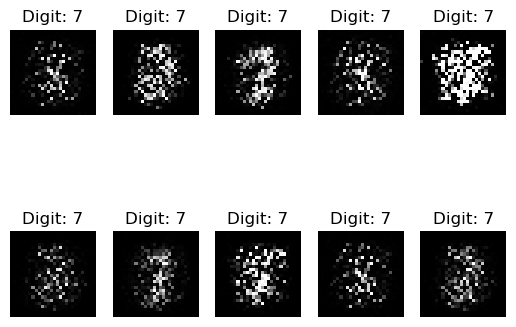

2/2 [==============================] - 0s 3ms/step
2000 [D loss: 0.22215232998132706, acc.: 49.21875%] [G loss: 4.398458480834961]
1/1 [==============================] - 0s 35ms/step


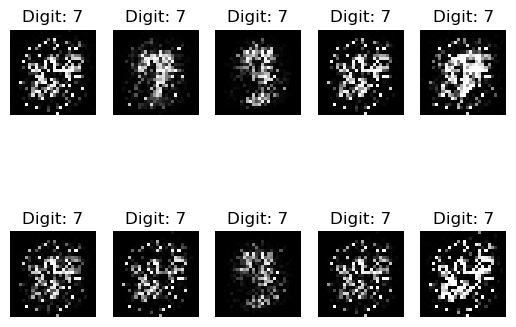

2/2 [==============================] - 0s 4ms/step
3000 [D loss: 0.297291100025177, acc.: 44.53125%] [G loss: 2.971212387084961]
1/1 [==============================] - 0s 31ms/step


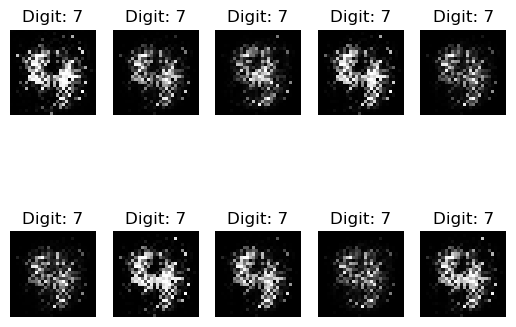

2/2 [==============================] - 0s 4ms/step
4000 [D loss: 0.2104327529668808, acc.: 50.0%] [G loss: 2.874950408935547]
1/1 [==============================] - 0s 21ms/step


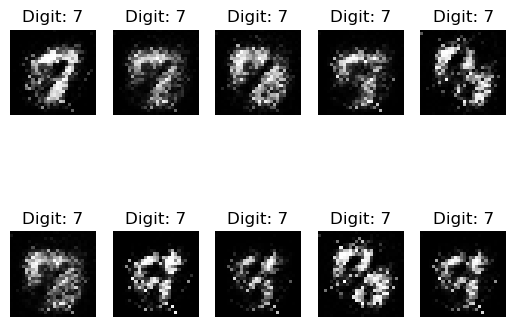

2/2 [==============================] - 0s 3ms/step
5000 [D loss: 0.3865148276090622, acc.: 44.53125%] [G loss: 2.351619243621826]
1/1 [==============================] - 0s 20ms/step


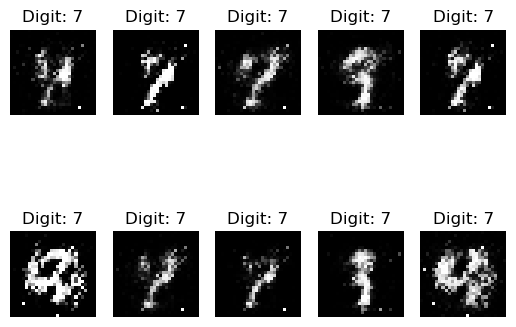

2/2 [==============================] - 0s 3ms/step
6000 [D loss: 0.5207572877407074, acc.: 42.96875%] [G loss: 2.371239185333252]
1/1 [==============================] - 0s 23ms/step


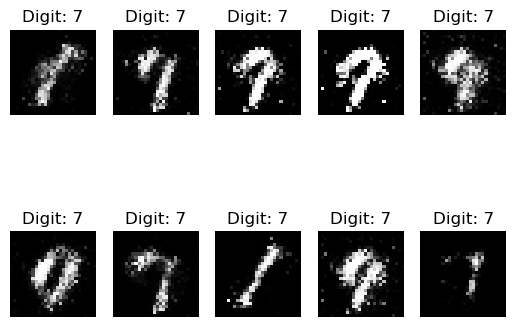

2/2 [==============================] - 0s 3ms/step
7000 [D loss: 0.3630504310131073, acc.: 43.75%] [G loss: 2.131716251373291]
1/1 [==============================] - 0s 21ms/step


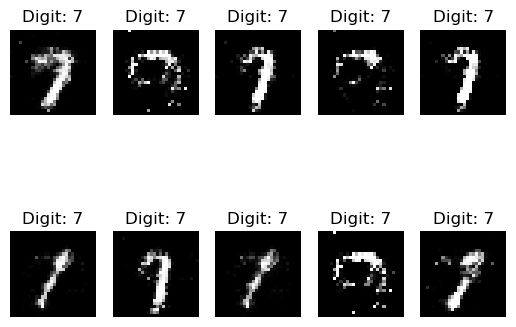

2/2 [==============================] - 0s 3ms/step
8000 [D loss: 0.4235256612300873, acc.: 46.09375%] [G loss: 2.0114026069641113]
1/1 [==============================] - 0s 30ms/step


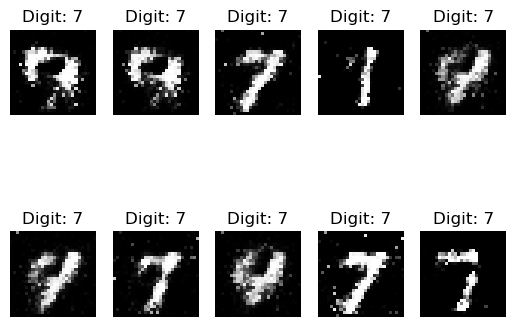

2/2 [==============================] - 0s 3ms/step
9000 [D loss: 0.4199477732181549, acc.: 45.3125%] [G loss: 2.2142107486724854]
1/1 [==============================] - 0s 21ms/step


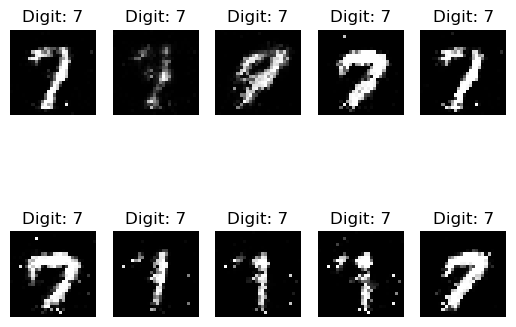

2/2 [==============================] - 0s 3ms/step


In [51]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load MNIST dataset
(X_train, Y_train), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)  # Reshape to (28, 28, 1)

# Generator with label input
def build_generator():
    noise_input = layers.Input(shape=(100,))
    label_input = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Embedding(10, 100)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    model_input = layers.multiply([noise_input, label_embedding])

    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return tf.keras.Model([noise_input, label_input], model(model_input))

generator = build_generator()

# Discriminator with label input
def build_discriminator():
    img_input = layers.Input(shape=(28, 28, 1))
    label_input = layers.Input(shape=(1,), dtype='int32')

    # Embedding the label input to match the shape of the image input
    label_embedding = layers.Embedding(10, 28 * 28)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((28, 28, 1))(label_embedding)

    # Concatenate the image and label embeddings along the channel dimension
    merged_input = layers.concatenate([img_input, label_embedding], axis=-1)

    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 2)))  # Update the input shape here
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return tf.keras.Model([img_input, label_input], model(merged_input))

discriminator = build_discriminator()

# Build and compile models
discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

gan_input_noise = layers.Input(shape=(100,))
gan_input_label = layers.Input(shape=(1,))
generated_image = generator([gan_input_noise, gan_input_label])
gan_output = discriminator([generated_image, gan_input_label])

gan = tf.keras.Model([gan_input_noise, gan_input_label], gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Training function with label smoothing
def train(epochs, batch_size=128, save_interval=200):
    for epoch in range(epochs):
        # Generate real images and real labels
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images, labels = X_train[idx], Y_train[idx]
        
        # Label smoothing: Real labels randomly between 0.9 and 1
        real = np.random.uniform(0.9, 1, (batch_size, 1))
        
        # Generate fake images and fake labels
        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict([noise, labels])
        fake = np.zeros((batch_size, 1))  # Fake labels remain 0

        # Train discriminator
        d_loss_real = discriminator.train_on_batch([real_images, labels], real)
        d_loss_fake = discriminator.train_on_batch([fake_images, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train generator
        g_loss = gan.train_on_batch([noise, labels], np.ones((batch_size, 1)))  # Real labels for generator

        # Print progress
        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch, digit=7)  # Change this to desired digit, e.g., '7' or '9'

# Function to save generated images for a specific digit
def save_images(epoch, digit=7):
    r, c = 2, 5  # Generate 10 images (2 rows, 5 columns)
    noise = np.random.normal(0, 1, (r * c, 100))
    labels = np.full((r * c,), digit)  # Generate the specific digit
    gen_images = generator.predict([noise, labels])
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].set_title(f"Digit: {digit}")
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the CGAN with label smoothing
train(epochs=10000, batch_size=64, save_interval=1000)



# Question 03

## **Generate noise vectors corresponding to two different digits (e.g., '3' and '8'). Perform interpolation between the two noise vectors and visualize how the generated images morph from one digit to the other.**



2/2 [==============================] - 0s 5ms/step
0 [D loss: 0.551372230052948, acc.: 47.65625%] [G loss: 0.39923158288002014]
1/1 [==============================] - 0s 143ms/step


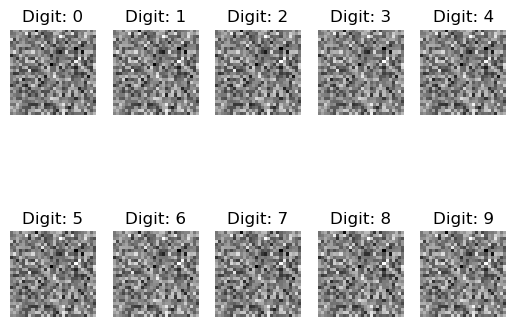

2/2 [==============================] - 0s 4ms/step
2000 [D loss: 0.07392711192369461, acc.: 99.21875%] [G loss: 4.9855055809021]
1/1 [==============================] - 0s 23ms/step


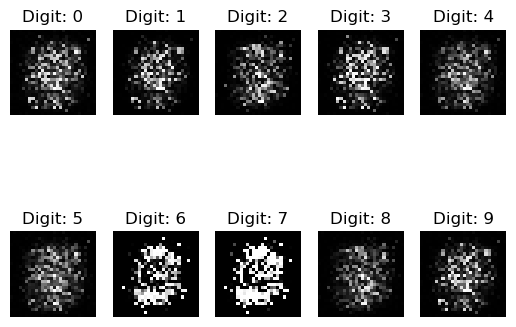

2/2 [==============================] - 0s 3ms/step
4000 [D loss: 0.29401495307683945, acc.: 91.40625%] [G loss: 4.460215091705322]
1/1 [==============================] - 0s 19ms/step


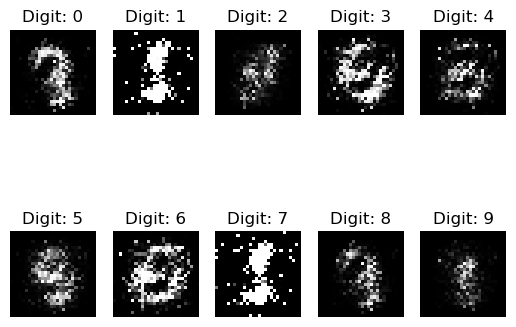

2/2 [==============================] - 0s 3ms/step
6000 [D loss: 0.3861616179347038, acc.: 84.375%] [G loss: 2.4243555068969727]
1/1 [==============================] - 0s 24ms/step


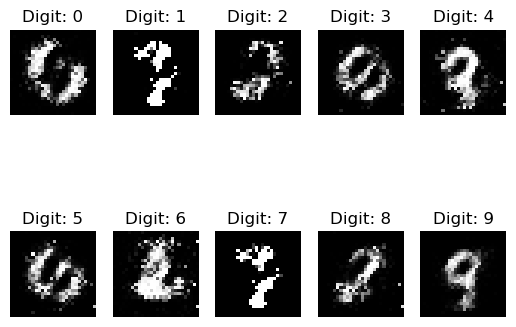

2/2 [==============================] - 0s 4ms/step
8000 [D loss: 0.30844853818416595, acc.: 86.71875%] [G loss: 2.0534682273864746]
1/1 [==============================] - 0s 29ms/step


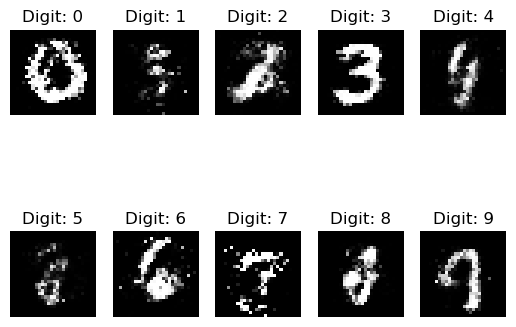

1/1 [==============================] - 0s 23ms/step


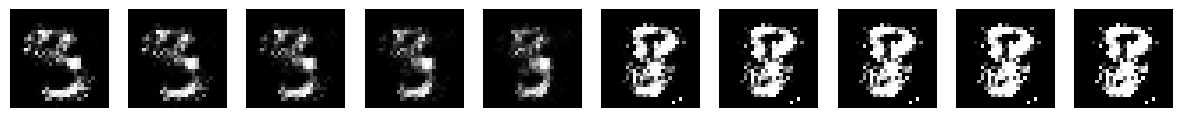

In [70]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Load MNIST dataset
(X_train, Y_train), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=-1)  # Reshape to (28, 28, 1)

# Generator with label input
def build_generator():
    noise_input = layers.Input(shape=(100,))
    label_input = layers.Input(shape=(1,), dtype='int32')
    label_embedding = layers.Embedding(10, 100)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    model_input = layers.multiply([noise_input, label_embedding])

    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_dim=100))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Dense(28 * 28 * 1, activation='tanh'))
    model.add(layers.Reshape((28, 28, 1)))

    return tf.keras.Model([noise_input, label_input], model(model_input))

# Discriminator with label input
def build_discriminator():
    img_input = layers.Input(shape=(28, 28, 1))
    label_input = layers.Input(shape=(1,), dtype='int32')

    label_embedding = layers.Embedding(10, 28 * 28)(label_input)
    label_embedding = layers.Flatten()(label_embedding)
    label_embedding = layers.Reshape((28, 28, 1))(label_embedding)

    merged_input = layers.concatenate([img_input, label_embedding], axis=-1)

    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(28, 28, 2)))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return tf.keras.Model([img_input, label_input], model(merged_input))

# Build generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Compile discriminator
discriminator.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy', metrics=['accuracy'])
discriminator.trainable = False

# GAN model
gan_input_noise = layers.Input(shape=(100,))
gan_input_label = layers.Input(shape=(1,))
generated_image = generator([gan_input_noise, gan_input_label])
gan_output = discriminator([generated_image, gan_input_label])

gan = tf.keras.Model([gan_input_noise, gan_input_label], gan_output)
gan.compile(optimizer=tf.keras.optimizers.Adam(0.0002), loss='binary_crossentropy')

# Training function
def train(epochs, batch_size=128, save_interval=200):
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images, labels = X_train[idx], Y_train[idx]

        noise = np.random.normal(0, 1, (batch_size, 100))
        fake_images = generator.predict([noise, labels])

        d_loss_real = discriminator.train_on_batch([real_images, labels], real)
        d_loss_fake = discriminator.train_on_batch([fake_images, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        g_loss = gan.train_on_batch([noise, labels], real)

        if epoch % save_interval == 0:
            print(f"{epoch} [D loss: {d_loss[0]}, acc.: {100 * d_loss[1]}%] [G loss: {g_loss}]")
            save_images(epoch)

# Function to save generated images
def save_images(epoch):
    r, c = 2, 5  # Generate 10 images (2 rows, 5 columns)
    noise = np.random.normal(0, 1, (r * c, 100))
    labels = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])  # Generate digits 0-9
    gen_images = generator.predict([noise, labels])
    gen_images = 0.5 * gen_images + 0.5  # Rescale to [0, 1]

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i, j].imshow(gen_images[cnt, :, :, 0], cmap='gray')
            axs[i, j].set_title(f"Digit: {labels[cnt]}")
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

# Train the CGAN for 10000 epochs
train(epochs=10000, batch_size=64, save_interval=2000)

# Interpolation code after training
noise_dim = 100
noise_3 = np.random.normal(0, 1, (1, noise_dim))
noise_8 = np.random.normal(0, 1, (1, noise_dim))

# Labels for digits '3' and '8'
label_3 = np.array([[3]])
label_8 = np.array([[8]])

# Number of interpolation steps
steps = 10
alphas = np.linspace(0, 1, steps)

# Interpolate between noise_3 and noise_8
interpolated_images = []
for alpha in alphas:
    interpolated_noise = (1 - alpha) * noise_3 + alpha * noise_8
    interpolated_images.append(generator.predict([interpolated_noise, label_3 if alpha < 0.5 else label_8]))

# Visualize the morphing images
plt.figure(figsize=(15, 3))
for i in range(steps):
    plt.subplot(1, steps, i + 1)
    plt.imshow(interpolated_images[i][0, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()
